In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math
import torch
import torchvision
from torch import optim
from torch import nn
import torch.utils.data
import torch.nn.functional as F
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split
from torch.autograd import Variable
from matplotlib import image as img
from torchvision import datasets, transforms, models
import torch.utils.data as data
from torch.utils.data import Dataset
import os

In [2]:
# Define the data transformations for data augmentation and normalization
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize images to a consistent size
    transforms.ToTensor(),  # Convert images to PyTorch tensors
])

augmentation = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(40),
    transforms.Resize((224, 224)),
    transforms.RandomResizedCrop(size=(224,224)),
    transforms.ToTensor(),
])

# Set the path to your dataset
data_dir = './pellegrin_db'

# Create a dataset from the image folders
dataset = datasets.ImageFolder(data_dir, transform=transform)
augmentation_ds = datasets.ImageFolder(data_dir, transform=augmentation)
dataset = torch.utils.data.ConcatDataset([dataset, augmentation_ds])

# Define the ratio for train and test split
train_ratio = 0.8  # 80% of the data for training, 20% for testing

# Calculate the sizes of the train and test sets
num_data = len(dataset)
num_train = int(train_ratio * num_data)
num_test = num_data - num_train

# Split the dataset into train and test sets
train_set, test_set = random_split(dataset, [num_train, num_test])

# Define batch size and create data loaders for train and test sets
batch_size = 16
train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_set, batch_size=batch_size, shuffle=False)

# Check the length of train and test sets
print(f"Number of training examples: {len(train_set)}")
print(f"Number of testing examples: {len(test_set)}")

# You can now use train_loader and test_loader for training and testing your binary classification model.



Number of training examples: 313
Number of testing examples: 79


In [3]:
classes = ('male_bighorn', 'female_bighorn')

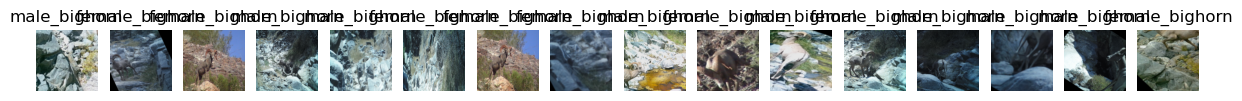

In [4]:
def show_images_labels(images, labels):
    fig, axes = plt.subplots(1, len(images), figsize=(15, 8))
    for i in range(len(images)):
        image = images[i].permute(1, 2, 0)  # Convert to (H, W, C) format
        label = classes[labels[i]]
        axes[i].imshow(image)
        axes[i].set_title(label)
        axes[i].axis('off')
    plt.show()

num_images_to_display = 4  # Customize this

# Iterate through the test_loader and display the specified number of images
displayed_images = 0
for batch in test_loader:
    images, labels = batch
    show_images_labels(images, labels)
    displayed_images += len(images)
    if displayed_images >= num_images_to_display:
        break

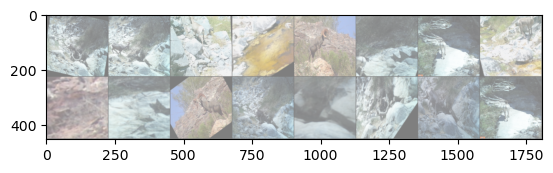

male_bighorn male_bighorn male_bighorn male_bighorn female_bighorn male_bighorn male_bighorn male_bighorn female_bighorn male_bighorn female_bighorn female_bighorn male_bighorn male_bighorn male_bighorn male_bighorn


In [5]:
# functions to show an image
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(train_loader)
images, labels = next(dataiter)

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join(f'{classes[labels[j]]:5s}' for j in range(batch_size)))

In [6]:
from transformers import ViTFeatureExtractor, ViTForImageClassification
model_name = "google/vit-base-patch16-224-in21k"
num_classes = 2  # Number of classes in your dataset
model = ViTForImageClassification.from_pretrained(model_name, num_labels=num_classes)

# Define the image feature extractor
feature_extractor = ViTFeatureExtractor(model_name)

C:\ProgramData\Anaconda3\lib\site-packages\scipy\__init__.py:155: UserWarning: A NumPy version >=1.18.5 and <1.25.0 is required for this version of SciPy (detected version 1.26.2
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
C:\Users\norma\AppData\Roaming\Python\Python39\site-packages\transformers\models\vit\feature_extraction_vit.py:28: FutureWarning: The class ViTFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use ViTImageProcessor instead.
  warnings.warn(


In [7]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)
print(torch.cuda.is_available())

True


In [8]:
def train(model, train_loader, val_loader, criterion, optimizer, epochs):
    a_train_loss = []
    a_train_accuracy = []
    a_val_loss = []
    a_val_accuracy = []
    
    for epoch in range(epochs):
        train_loss = 0
        train_corrects = 0
        total = 0 
        for batch, (data, target) in enumerate(train_loader):
            data, target = Variable(data), Variable(target)
            data, target = data.to(device), target.to(device)

            outputs = model(data).logits
            loss = criterion(outputs, target)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            train_loss += loss.item()
            pred = torch.max(outputs.data, 1)[1]
            train_corrects += (pred == target).sum().item()

        train_loss /= len(train_loader.dataset)
        train_acc = train_corrects/ len(train_loader.dataset)

        model.eval()
        val_loss = 0.0
        val_corrects = 0
        with torch.no_grad():
            for batch, (data, target) in enumerate(val_loader):
                data, target = Variable(data), Variable(target)
                data, target = data.to(device), target.to(device)

                outputs = model(data).logits
                loss = criterion(outputs, target)

                val_loss += loss.item()
                pred = torch.argmax(outputs, 1)
                val_corrects += (pred == target).sum().item()

        val_loss /= len(val_loader.dataset)
        val_acc = val_corrects/len(val_loader.dataset)
        
        a_train_loss.append(train_loss)
        a_train_accuracy.append(train_acc)
        a_val_loss.append(val_loss)
        a_val_accuracy.append(val_acc)
        
        print(f"Epoch {epoch+1}/{epochs} - Training Loss: {train_loss:.4f}, Train Accuracy: {train_acc:.4f}, "
                  f"Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_acc:.4f}")
    return model, a_train_loss, a_train_accuracy, a_val_loss, a_val_accuracy

In [9]:
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
criterion = nn.CrossEntropyLoss()
model, train_loss, train_accuracy, test_loss, test_accuracy = train(model,train_loader,test_loader,criterion,optimizer, 10)

KeyboardInterrupt: 

In [10]:
training_stats = pd.DataFrame({
    'train_loss': train_loss,
    'train_accuracy': train_accuracy,
    'test_loss': test_loss,
    'test_accuracy': test_accuracy
})
training_stats.to_csv('./training_stats/bighorn_ViT_stats.csv', index=False)
torch.save(model,'./models/bighorn_male-female_classification_with_ViT.pth' )

NameError: name 'train_loss' is not defined

In [12]:
model = torch.load('./models/bighorn_male-female_classification_with_ViT.pth', weights_only = False)

In [14]:
model.eval()

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

corr = 0
total = 0

with torch.no_grad():
    for images,targets in test_loader:
        images,targets=images.to(device),targets.to(device)
        
        output = model(images).logits
        
        _, prediction = torch.max(output.data, 1)
        total += targets.size(0)
        corr += (prediction== targets).sum().item()

print('Accuracy of the model on all test Data: %d %%' % ( 100 * corr / total))

Accuracy of the model on all test Data: 89 %
